# Import lib and dataset

In [36]:
import pandas as pd
import json
import numpy as np 
import matplotlib.pyplot as plt
from transformers import set_seed 
import nlpaug.augmenter.word as naw 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report 
from skmultilearn.problem_transform import BinaryRelevance 
from sklearn.feature_extraction.text import CountVectorizer 
import torch 
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification

In [37]:
# set width for dataframe display
pd.set_option('display.max_colwidth', 200)
# dataset_url = "https://git.io/nlp-with-transformers"
# df_issues = pd.read_json(dataset_url, lines=True)
# print(f"DataFrame shape: {df_issues.shape}")

## Load data to json file

In [38]:
df_issues = pd.read_json("issues.json", lines=True)

In [39]:
cols = ["url", "id", "title", "user", "labels", "state", "created_at", "body"]
df_issues.loc[2, cols].to_frame()

,2
url,https://api.github.com/repos/huggingface/transformers/issues/11044
id,849529761
title,[DeepSpeed] ZeRO stage 3 integration: getting started and issues
user,"{'login': 'stas00', 'id': 10676103, 'node_id': 'MDQ6VXNlcjEwNjc2MTAz', 'avatar_url': 'https://avatars.githubusercontent.com/u/10676103?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users..."
labels,"[{'id': 2659267025, 'node_id': 'MDU6TGFiZWwyNjU5MjY3MDI1', 'url': 'https://api.github.com/repos/huggingface/transformers/labels/DeepSpeed', 'name': 'DeepSpeed', 'color': '4D34F7', 'default': False..."
state,open
created_at,2021-04-02 23:40:42
body,"**[This is not yet alive, preparing for the release, so please ignore for now]**\r\n\r\nThe DeepSpeed ZeRO-3 has been integrated into HF `transformers`. \r\n\r\nWhile I tried to write tests for a ..."


In [40]:
# print all the columns
print(df_issues.columns)

Index(['url', 'repository_url', 'labels_url', 'comments_url', 'events_url',
       'html_url', 'id', 'node_id', 'number', 'title', 'user', 'labels',
       'state', 'locked', 'assignee', 'assignees', 'milestone', 'comments',
       'created_at', 'updated_at', 'closed_at', 'author_association',
       'active_lock_reason', 'body', 'performed_via_github_app',
       'pull_request'],
      dtype='object')


## Process label

In [41]:
df_issues["labels"] = (df_issues["labels"]
 .apply(lambda x: [meta["name"] for meta in x]))
df_issues[["labels"]].head()

,labels
0,[]
1,[]
2,[DeepSpeed]
3,[]
4,[]


In [42]:
df_counts = df_issues["labels"].explode().value_counts()
print(f"Number of labels: {len(df_counts)}") 
df_counts.head(10).to_frame().T

Number of labels: 65


labels,wontfix,model card,Core: Tokenization,New model,Core: Modeling,Help wanted,Good First Issue,Usage,Core: Pipeline,Feature request
count,2284,649,106,98,64,52,50,46,42,41


In [43]:
label_map = {"Core: Tokenization": "tokenization",
 "New model": "new model",
 "Core: Modeling": "model training",
 "Usage": "usage",
 "Core: Pipeline": "pipeline",
 "TensorFlow": "tensorflow or tf",
 "PyTorch": "pytorch",
 "Examples": "examples",
 "Documentation": "documentation"}

In [44]:
def filter_lables(x): 
    return [label_map[label] for label in x if label in label_map] 
df_issues["labels"] = df_issues["labels"].apply(filter_lables) 
all_labels = list(label_map.values()) 

In [45]:
df_counts = df_issues["labels"].explode().value_counts()
print(f"Number of labels: {len(df_counts)}")
df_counts.head(10).to_frame().T

Number of labels: 9


labels,tokenization,new model,model training,usage,pipeline,tensorflow or tf,pytorch,documentation,examples
count,106,98,64,46,42,41,37,28,24


## save the unlabels data

In [46]:
df_issues["split"] = "unlabeled"
mark = df_issues["labels"].apply(lambda x: len(x) > 0)
df_issues.loc[mark, "split"] = "labeled"
df_issues["split"].value_counts().to_frame()

,count
split,
unlabeled,9489
labeled,441


In [47]:
# print some examples
for colume in ['title', 'body', 'labels']:
    print(f"{colume}: {df_issues[colume].iloc[26][:500]}\n")

title: Add new CANINE model

body: # 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually en

labels: ['new model']



In [48]:
# concat the title and body 
df_issues['text'] = (df_issues
                     .apply(lambda x: f"{x['title']} +  {x['body']}", axis=1))

In [49]:
df_issues['text'].head()

0    Potential incorrect application of layer norm in BlenderbotSmallDecoder +  In BlenderbotSmallDecoder,  layer norm is applied only on the token embeddings, and not on the hidden_states, whereas in ...
1    Multi-GPU seq2seq example evaluation significantly slower than legacy example evaluation +  \r\n### Who can help\r\n@patil-suraj @sgugger \r\n\r\nModels:\r\nT5\r\n\r\n## Information\r\n\r\nI've be...
2    [DeepSpeed] ZeRO stage 3 integration: getting started and issues +  **[This is not yet alive, preparing for the release, so please ignore for now]**\r\n\r\nThe DeepSpeed ZeRO-3 has been integrated...
3    Can't load model to estimater +  I was trying to follow the Sagemaker instructions [here](https://docs.aws.amazon.com/sagemaker/latest/dg/deploy-model.html) to load the model I just trained and te...
4    [LXMERT] Unclear what img_tensorize does with color spaces +  ## Environment info\r\n\r\n- `transformers` version: Not using transformers directly, I'm loading a model "unc-nl

In [50]:
len_before = len(df_issues)
df_issues = df_issues.drop_duplicates(subset=['text'])
print(f"Remove {(len_before - len(df_issues)) / len_before:.2%} duplicates.")


Remove 1.88% duplicates.


## Plot the dataset

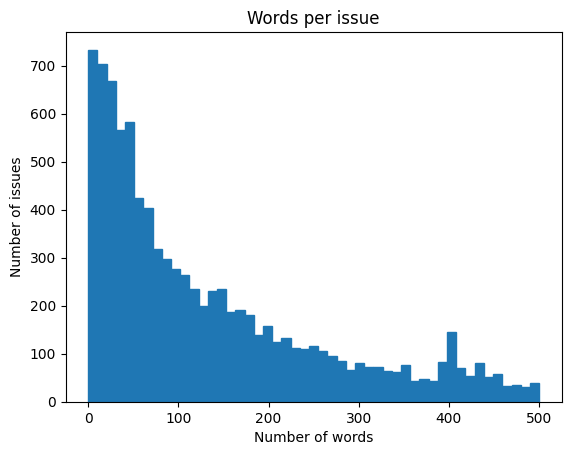

In [51]:
df_issues['text'].str.split().apply(len).hist(bins = np.linspace(0, 500, 50), grid=False, edgecolor='C0') 
plt.title("Words per issue") 
plt.xlabel("Number of words")
plt.ylabel("Number of issues")
plt.show()

# Creating training set

In [52]:
#create balance split by using sk ml
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit([all_labels])
mlb.transform([["tokenization", "new model"], ["pytorch"]])  # example of target encoding

array([[0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

## split dataset

In [53]:
from skmultilearn.model_selection import iterative_train_test_split 
def balanced_split(df , test_size = 0.5): 
    ind = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["labels"]) # transform labels to binary
    ind_train , _ , ind_test, _  = iterative_train_test_split(ind, labels, test_size=test_size) # split data
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:, 0]]  # return train and test DataFrames

Example of balance split
![Alt text](image-1.png)

In [54]:
from sklearn.model_selection import train_test_split
df_clean = df_issues[["text" , "labels", "split"]].reset_index(drop=True).copy() 
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]].copy()
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]].copy()

np.random.seed(0)
 
df_train , df_tmp = balanced_split(df_sup, test_size=0.5) 
df_valid , df_test = balanced_split(df_tmp, test_size=0.5) 

## Create datasetDict

In [55]:
from datasets import Dataset, DatasetDict 
ds = DatasetDict({"train": Dataset.from_pandas(df_train.reset_index(drop=True)),
                  "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
                    "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
                    "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True))
                  })

## Creating Training slices

In [56]:
np.random.seed(0)
all_indices = np.expand_dims(list(range(len(ds["train"]))) , axis=1) 
print(f"Number of samples: {len(all_indices)}")
indices_pool = all_indices 
lables = mlb.transform(ds["train"]["labels"]) 
train_samples =  [8, 16, 32, 64, 128] 
train_slices , last_k = [], 0 
for i , k in enumerate(train_samples):
    # split off samples necessary to fill the gap to the next split size
    indices_pool, lables, new_slice, _ = iterative_train_test_split(indices_pool, lables, (k - last_k)/len(lables))
    last_k = k 
    if i == 0:
        train_slices.append(new_slice)
    else: train_slices.append(np.concatenate([train_slices[-1], new_slice]))
# add full dataset as last slice 
train_slices.append(all_indices) , train_samples.append(len(ds["train"]))
train_slices = [np.squeeze(x) for x in train_slices]

Number of samples: 223


In [57]:
def prepare_labels(batch): 
    batch["label_ids"] = mlb.transform(batch["labels"])
    return batch
ds = ds.map(prepare_labels, batched=True) 

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [58]:
df_train.head()

,text,labels
26,Add new CANINE model + # 🌟 New model addition\r\n\r\n## Model description\r\n\r\nGoogle recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncod...,[new model]
107,Please implement DUMA: Reading Comprehension with Transposition Thinking + # 🚀 Feature request\r\n\r\n<!-- A clear and concise description of the feature proposal.\r\n Please provide a link t...,[new model]
264,Can DeepSpeed ZeRO-3 be applied for training? + # 🌟 New model addition\r\n\r\nWe have applied DeepSpeed v0.3.10(ZeRO-2) on T5 training. \r\nI heard DeepSpeed ZeRO-3 library has been released 10 ...,[new model]
484,XLSR-53 + # 🚀 Feature request\r\n\r\nIs it possible to use XLSR-53 with transformers in the near future? \r\n,[new model]
566,[examples] should all examples support the predict stage? + This is part of the ongoing effort to sync the example scripts.\r\n\r\nIn https://github.com/huggingface/transformers/issues/10437#issu...,[examples]


In [59]:
def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    for run in micro_scores.keys():
        if run == current_model:
            print(run)
            ax0.plot(sample_sizes, micro_scores[run], label = run , linewidth=2)            
            ax1.plot(sample_sizes, macro_scores[run], label = run , linewidth=2)
        else:
            print(run)
            ax0.plot(sample_sizes, micro_scores[run], label=run,linestyle="dashed")
            ax1.plot(sample_sizes, macro_scores[run], label=run,linestyle="dashed")
    ax0.set_title("Micro F1 scores")
    ax1.set_title("Macro F1 scores")
    ax0.set_ylabel("Test set F1 score")
    ax0.legend(loc="lower right")
    for ax in [ax0, ax1]:
        ax.set_xlabel("Number of training samples")
        ax.set_xscale("log")
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)
        ax.minorticks_off()
    plt.tight_layout()
    plt.show()
# plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes")

In [60]:
import torch
device  = "cuda" if torch.cuda.is_available() else "cpu"

## Plot the metrics

### init macro and micro

In [61]:
# import defaultdict
from collections import defaultdict
macro_scores = defaultdict(list,
            {'Naive Bayes': [0.23288166214995487,
              0.21006897585844955,
              0.24086240556828795,
              0.25730500818220114,
              0.28271105113210376,
              0.27403710305671086],
             'Zero-Shot': [0.3869340923536515,
              0.3869340923536515,
              0.3869340923536515,
              0.3869340923536515,
              0.3869340923536515,
              0.3869340923536515],
             'Naive Bayes + Aug': [0.27235449735449735,
              0.278589655958077,
              0.33758862806420187,
              0.4415159953502743,
              0.4563280715286368,
              0.4832651770367019],
             'Embedding GPT2': [0.2359519022412816,
              0.22399328684158407,
              0.24991158684522524,
              0.3304358431861561,
              0.31501683091623417,
              0.30677622391019166]})

micro_scores = defaultdict(list,
            {'Naive Bayes': [0.3604651162790698,
              0.30208333333333337,
              0.41081081081081083,
              0.4435483870967742,
              0.5046728971962616,
              0.5346534653465347],
             'Zero-Shot': [0.4444444444444445,
              0.4444444444444445,
              0.4444444444444445,
              0.4444444444444445,
              0.4444444444444445,
              0.4444444444444445],
             'Naive Bayes + Aug': [0.5081081081081081,
              0.4954128440366973,
              0.5084745762711865,
              0.5679012345679012,
              0.5590551181102362,
              0.578125],
             'Embedding GPT2': [0.3167155425219942,
              0.36363636363636365,
              0.39452054794520547,
              0.5118483412322274,
              0.46564885496183206,
              0.5402843601895735]})


Naive Bayes
Zero-Shot
Naive Bayes + Aug
Embedding GPT2


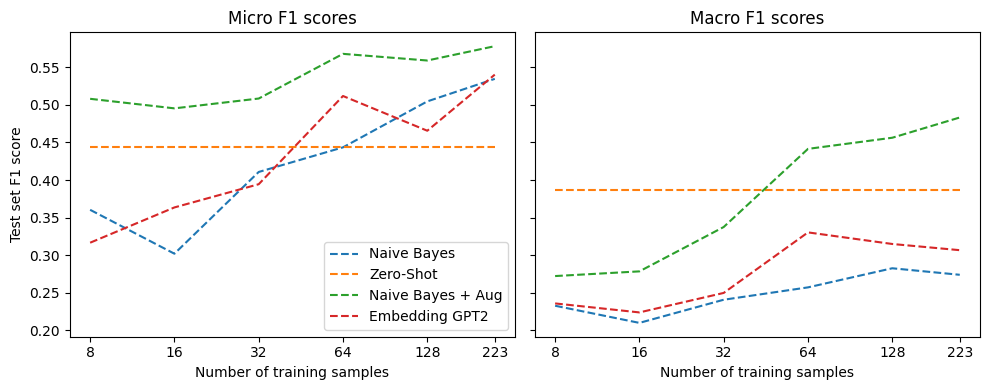

In [62]:
plot_metrics(micro_scores, macro_scores, train_samples, "Embedding")

# Fine tune Vanilla Transformer

## Load the base model

In [63]:
model_ckpt  = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt) 
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, max_length=128)
ds_enc = ds.map(tokenize, batched=True) 
ds_enc = ds_enc.remove_columns(["text", "labels"])

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [64]:
ds_enc

DatasetDict({
    train: Dataset({
        features: ['label_ids', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 223
    })
    valid: Dataset({
        features: ['label_ids', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 106
    })
    test: Dataset({
        features: ['label_ids', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 111
    })
    unsup: Dataset({
        features: ['label_ids', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9303
    })
})

## Convert label_ids to float


In [65]:
ds_enc.set_format("torch") 
ds_enc = ds_enc.map(lambda x: {'label_ids_f': x['label_ids'].to(torch.float)},
                               remove_columns = ["label_ids"])
ds_enc = ds_enc.rename_column("label_ids_f", "label_ids")

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [66]:
from transformers import Trainer, TrainingArguments
training_args_fine_tune = TrainingArguments(
 output_dir="./results", num_train_epochs=20, learning_rate=7e-5,
 lr_scheduler_type='constant', per_device_train_batch_size=4,
 per_device_eval_batch_size=256, weight_decay=0.0,
 evaluation_strategy="epoch", save_strategy="epoch",logging_strategy="epoch",
 load_best_model_at_end=True, metric_for_best_model='micro f1',
 save_total_limit=1, log_level='error')

In [67]:
from scipy.special import expit as sigmoid

def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = sigmoid(pred.predictions)
    y_pred = (y_pred>0.5).astype(float)
    clf_dict = classification_report(y_true, y_pred, target_names=all_labels,
    zero_division=0, output_dict=True)
    return {"micro f1": clf_dict["micro avg"]["f1-score"],
    "macro f1": clf_dict["macro avg"]["f1-score"]}


In [68]:
config = AutoConfig.from_pretrained(model_ckpt)
config.num_labels = len(all_labels)
config.problem_type = "multi_label_classification"
for train_slice in train_slices:
 model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
 config=config)
 trainer = Trainer(
 model=model, tokenizer=tokenizer,
 args=training_args_fine_tune,
 compute_metrics=compute_metrics,
 train_dataset=ds_enc["train"].select(train_slice),
 eval_dataset=ds_enc["valid"],)
 trainer.train()
 pred = trainer.predict(ds_enc["test"])
 metrics = compute_metrics(pred)
 macro_scores["Fine-tune (vanilla)"].append(metrics["macro f1"])
 micro_scores["Fine-tune (vanilla)"].append(metrics["micro f1"])
plot_metrics(micro_scores, macro_scores, train_samples, "Fine-tune (vanilla)")

{'loss': 0.6165, 'learning_rate': 7e-05, 'epoch': 1.0}


NameError: name 'sigmoid' is not defined